# Plot differences between epochs 
#### From files in ./analogue_data/analogue_differences

### Functions

In [2]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/portal/script/python/precip_Cristina')   # alice
sys.path.append('/home/portal/script/python')                   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

### Directories

In [4]:
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/case-studies_byNode/'

# alice
CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
ERA5_dir = '/work_big/users/clima/portal/ERA5/'
CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
fig_dir = './figures/'
diff_dir = './analogue_data/analogue_differences/' 

### Variable

In [5]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure
varname = 'psl'  # Variable to compute the difference between analogues, e.g. 'zg' for geopotential height

### Event

In [6]:
# Event
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
lselect = f'node{no_node}-extreme{no_event}-alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

### Analogue selection

In [7]:
# Quantile
qtl_LE = 0.99

# Number of ensemble members
no_membs = 10
list_membs = [name for name in os.listdir(CRCM5_dir + varname) if os.path.isdir(os.path.join(CRCM5_dir + varname, name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members

# Number of ensemble members for KS statistics
no_membs_ks = 10  # For KS statistics, we use only one
if no_membs_ks > no_membs:
    no_membs_ks = no_membs  # If the number of members for KS statistics is greater than available, set it to available members

# Epochs
list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
no_epochs = len(list_year_ranges)

# Difference between epochs
list_diff_indices = [[0,1],[0,2],[1,2]]  # Define the indices of epochs to compare

### Upload Euclidean distance of analogues from event

In [8]:
# Load ensemble data
ensemble_data = []
for i, year_range in enumerate(list_year_ranges):
    epoch_data = {}
    for memb in list_membs:
        # Construct the file path
        file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
        # Load the data from the npz file
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        # Load the data
        data = np.load(file_path, allow_pickle=True)
        times = data['times']
        distances = data['distances']
        epoch_data[memb] = {'times': times, 'distances': distances}
    ensemble_data.append(epoch_data)
no_analogues_LE = len(ensemble_data[0][list_membs[0]]['times'])  # Number of analogues per member

# Load ERA5 data
file_path_ERA5 = f'./analogue_data/times_distances_analogues-mslp_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_2004-2023_ERA5.npz'
file_path_ERA5 = "./analogue_data/times_distances_analogues-mslp_node1-event1-alertregions_99pct_2004-2023_ERA5.npz"
if not os.path.exists(file_path_ERA5):
    print(f"File not found: {file_path_ERA5}")
# Load the data
data_ERA5 = np.load(file_path_ERA5, allow_pickle=True)

In [9]:
# Distance from event
# CRCM5-LE distances
list_distances = []  # Initialize distances array for plotting
mean_dist = np.zeros(no_epochs)  # Initialize mean distance array for plotting
for i in range(len(list_year_ranges)):
    distances = np.zeros(no_analogues_LE * no_membs)  # Initialize distances array for plotting
    for im, memb in enumerate(list_membs):
        # Extract distances for the current member and epoch
        distances[im*no_analogues_LE:(im+1)*no_analogues_LE] = ensemble_data[i][memb]['distances']
    list_distances.append(distances)  # Append distances for the current epoch
    mean_dist[i] = np.mean(distances)  # Calculate mean distance for the current epoch

# ERA5 distances
distances_ERA5 = data_ERA5['distances']

### Plot distance from event in the different epochs

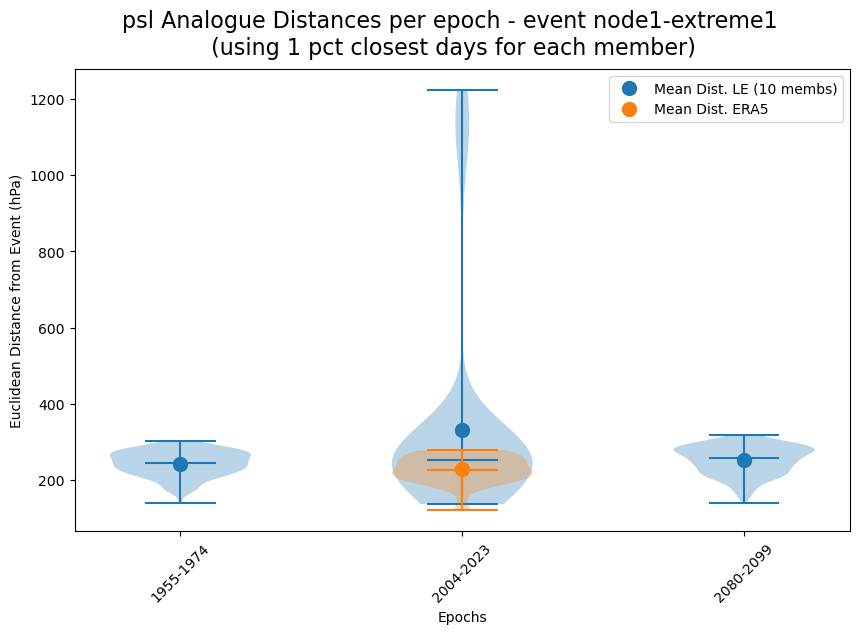

In [10]:

# Plot distance from event in the different epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
fig.suptitle(f"{varname} Analogue Distances per epoch - event node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16) 

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# Plot violin 
vp = ax.violinplot(list_distances, showmeans=False, showmedians=True, showextrema=True)
median_color = vp['cmedians'].get_color() 
# Plot the mean distance for the epoch
ax.plot(np.arange(1,no_epochs+1), mean_dist, marker='o', color=median_color, markersize=10, label=f'Mean Dist. LE ({no_membs} membs)', linewidth=0)

# Plot ERA5 violin
vp = ax.violinplot(distances_ERA5, positions=[2], showmeans=False, showmedians=True, showextrema=True)
median_color = vp['cmedians'].get_color() 
# Plot the mean distance
ax.plot(2, distances_ERA5.mean(), marker='o', color=median_color, markersize=10, label=f'Mean Dist. ERA5', linewidth=0)

# Ticks and labels
ax.set_xticks(range(1, no_epochs+1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
ax.set_ylabel('Euclidean Distance from Event (hPa)')
ax.legend()

# Save the figure
fig.savefig(f"{fig_dir}analogue-distances-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)

### Upload difference (+ significance) files

In [11]:
list_ds_diff = []  # List to store difference datasets
list_str_diff = []  # List to store string representations of differences
list_ds_ks_stats = []  # List to store KS statistics datasets
for i in range(len(list_diff_indices)):
    year_range1 = list_year_ranges[list_diff_indices[i][0]]
    str_year_range1 = "-".join(str(x) for x in year_range1)
    year_range2 = list_year_ranges[list_diff_indices[i][1]]
    str_year_range2 = "-".join(str(x) for x in year_range2)
    list_str_diff.append(f'{str_year_range2} - {str_year_range1}')  # Store the string representation of the difference
    suffix_file = f"_{varname}_{lselect}_{int(100*qtl_LE)}pct_diff{str_year_range2}_{str_year_range1}_CRCM5_{no_membs}membs.nc"
    # Load analogue differences
    diff_file = f'{diff_dir}LE-analogue-difference{suffix_file}'
    if not os.path.exists(diff_file):
        print(f'File {diff_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_diff = xr.open_dataset(diff_file)
    list_ds_diff.append(ds_diff)
    # Load KS statistics
    significance_file = f'{diff_dir}LE-analogue-KS-statistics{suffix_file}'
    if not os.path.exists(significance_file):
        print(f'File {significance_file} does not exist. Skipping epoch {i+1}.')
        continue
    ds_ks_stats = xr.open_dataset(significance_file)
    list_ds_ks_stats.append(ds_ks_stats)

### Plot differences

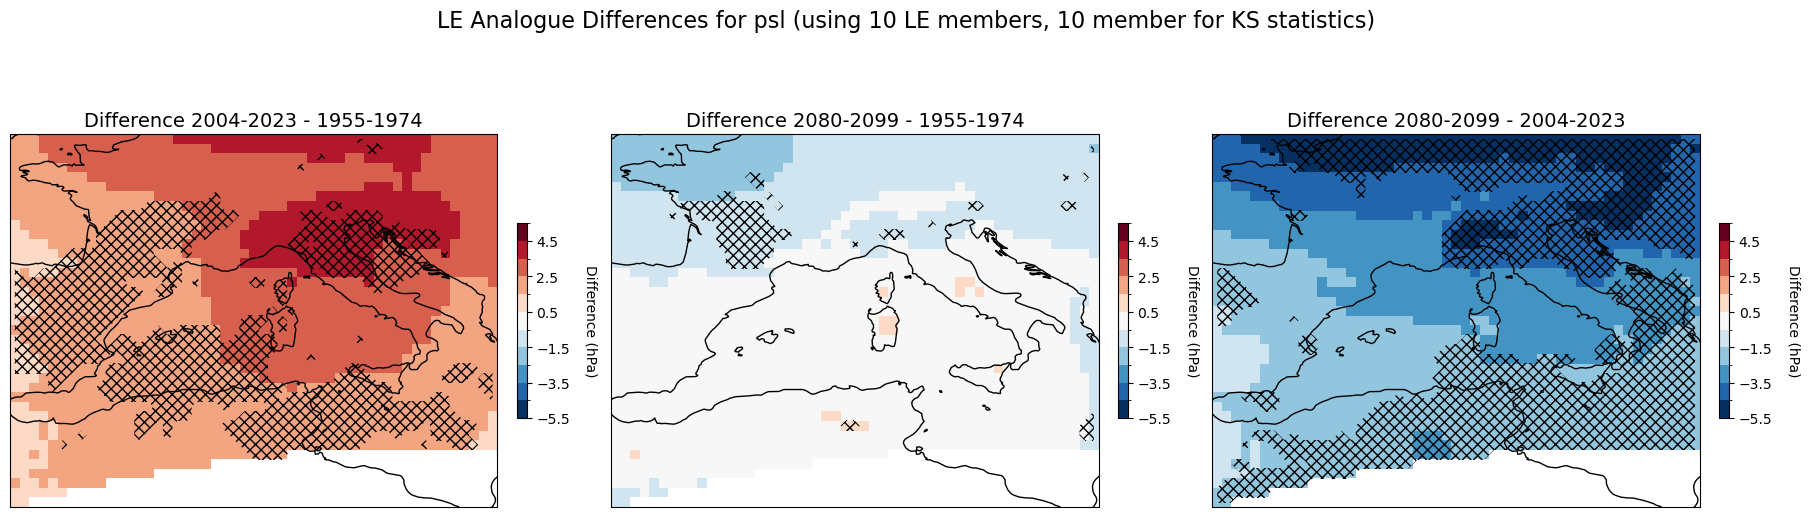

In [13]:
# Create subplots with Cartopy projection
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=True
)
axes = axes.flatten()

# Colormap and normalization
# Define discrete color levels (e.g., 5 bins from -10 to 10)
if varname == 'psl':
    bounds = np.arange(-5.5, 6, 1)  # Bin edges for geopotential height differences
elif varname == 'zg':
    bounds = np.arange(-15,16,2)  # Bin edges
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

# Define a discrete colormap (must match number of bins)
cmap = plt.get_cmap('RdBu_r', len(bounds) - 1)  # E.g., 6 discrete colors

# Plot each dataset
for i in range(len(list_ds_diff)):
    ax = axes[i]
    ds_diff = list_ds_diff[i][varname].squeeze()  # Extract the variable from the dataset
    ds_pvalue = list_ds_ks_stats[i].sel(output='pvalue', size_ensemble=no_membs_ks)['mean'].squeeze()

    # Plot assuming ds_diff is 2D (lat, lon)
    if varname == 'zg':
        ds_diff *= 9.8  # Convert geopotential height to hPa
    im = ds_diff.plot.imshow(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    # Plot significance using KS statistics
    significant_mask = ds_pvalue.values < 0.05
    # Contour significant areas
    if significant_mask.any():
        ax.contourf(
            ds_diff['lon'], ds_diff['lat'], significant_mask,
            levels=[0.5, 1.5], 
            colors='none',      # no fill color
            hatches=['xxx'],
            transform=ccrs.PlateCarree()
        )

    # Add map features
    ax.coastlines()
    ax.set_title(f"Difference {list_str_diff[i]}", fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Difference (hPa)', rotation=270, labelpad=20)

# Figure title
fig.suptitle(f"LE Analogue Differences for {varname} (using {no_membs} LE members, {no_membs_ks} member for KS statistics)", fontsize=16)

# Show plot
plt.show()

# Save the figure
fig.savefig(f"{fig_dir}{varname}_analogue-differences-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs_sign-{no_membs_ks}membs.png", bbox_inches='tight', dpi=300)

In [14]:
print(f"{fig_dir}{varname}_analogue-differences-{var_analogues}_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs_sign-{no_membs_ks}membs.png")

./figures/psl_analogue-differences-psl_node1-extreme1-alertregions_99pct_CRCM5_10membs_sign-10membs.png
